In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

/tmp/ipykernel_151987/2115483293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-23 08:41:34.544702: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 08:41:34.579150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 08:4

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

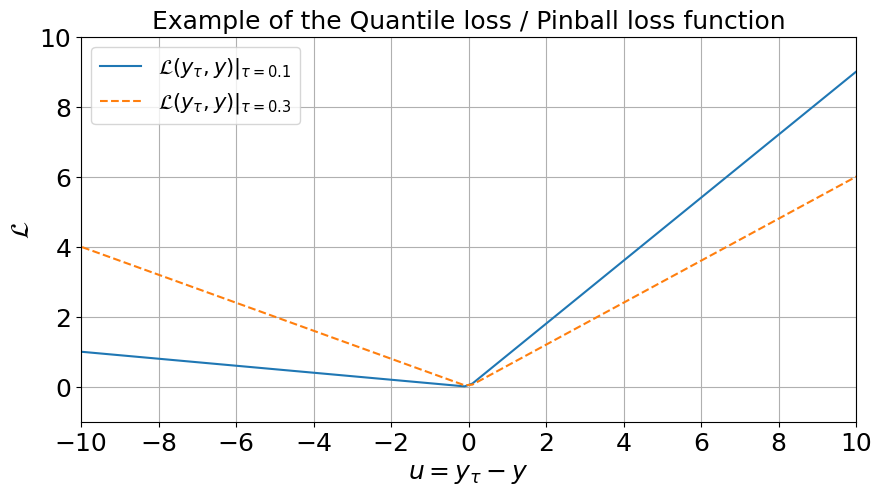

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.4
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.3}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [7]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

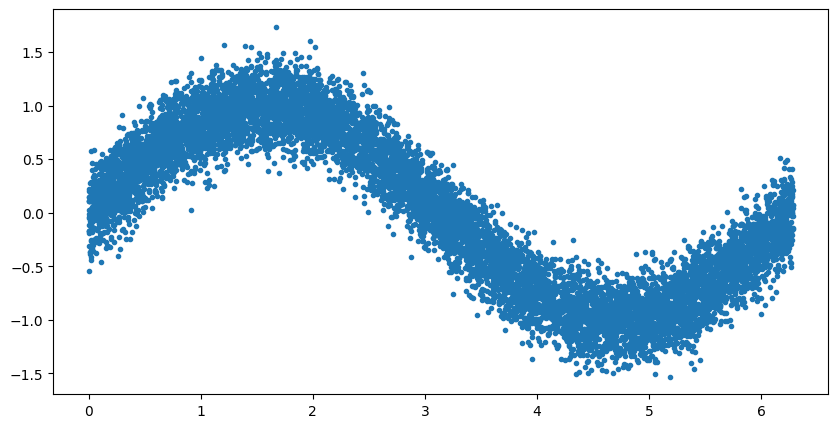

In [8]:
x,y = draw_sample_sin(10000,0.2)
plt.plot(x,y,'.')

In [9]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number: 100%|██████████| 19/19 [00:00<00:00, 33.03it/s]

Training loss [0.5915794] Validation loss [0.46882632]
----New best validation loss---- [0.46882632]
Epoch 2



Batch number: 100%|██████████| 19/19 [00:00<00:00, 470.70it/s]

Training loss [0.43542594] Validation loss [0.40144715]
----New best validation loss---- [0.40144715]
Epoch 3



Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.97it/s]


Training loss [0.3908085] Validation loss [0.37200332]
----New best validation loss---- [0.37200332]
Epoch 4


Batch number: 100%|██████████| 19/19 [00:00<00:00, 534.72it/s]

Training loss [0.36981186] Validation loss [0.35564908]
----New best validation loss---- [0.35564908]
Epoch 5



Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.32it/s]

Training loss [0.35653132] Validation loss [0.3448172]


----New best validation loss---- [0.3448172]
Epoch 6


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.34it/s]

Training loss [0.34585613] Validation loss [0.33479458]


----New best validation loss---- [0.33479458]
Epoch 7


Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.66it/s]

Training loss [0.3360692] Validation loss [0.32562187]


----New best validation loss---- [0.32562187]
Epoch 8


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.03it/s]

Training loss [0.32741252] Validation loss [0.31566793]


----New best validation loss---- [0.31566793]
Epoch 9


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.16it/s]

Training loss [0.32066035] Validation loss [0.3082265]


----New best validation loss---- [0.3082265]
Epoch 10


Batch number: 100%|██████████| 19/19 [00:00<00:00, 505.00it/s]

Training loss [0.31279436] Validation loss [0.3022753]


----New best validation loss---- [0.3022753]
Epoch 11


Batch number: 100%|██████████| 19/19 [00:00<00:00, 556.37it/s]

Training loss [0.3069787] Validation loss [0.2966348]


----New best validation loss---- [0.2966348]
Epoch 12


Batch number: 100%|██████████| 19/19 [00:00<00:00, 607.66it/s]

Training loss [0.30050254] Validation loss [0.2893485]


----New best validation loss---- [0.2893485]
Epoch 13


Batch number: 100%|██████████| 19/19 [00:00<00:00, 618.71it/s]

Training loss [0.29507756] Validation loss [0.2860009]


----New best validation loss---- [0.2860009]
Epoch 14


Batch number: 100%|██████████| 19/19 [00:00<00:00, 596.40it/s]

Training loss [0.29030153] Validation loss [0.28033984]


----New best validation loss---- [0.28033984]
Epoch 15


Batch number: 100%|██████████| 19/19 [00:00<00:00, 597.54it/s]

Training loss [0.28523403] Validation loss [0.27519813]


----New best validation loss---- [0.27519813]
Epoch 16


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.69it/s]

Training loss [0.28083268] Validation loss [0.27305895]


----New best validation loss---- [0.27305895]
Epoch 17


Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.19it/s]

Training loss [0.27746776] Validation loss [0.26933262]


----New best validation loss---- [0.26933262]
Epoch 18


Batch number: 100%|██████████| 19/19 [00:00<00:00, 615.02it/s]

Training loss [0.27333844] Validation loss [0.2663155]


----New best validation loss---- [0.2663155]
Epoch 19


Batch number: 100%|██████████| 19/19 [00:00<00:00, 613.87it/s]

Training loss [0.2696453] Validation loss [0.26095358]


----New best validation loss---- [0.26095358]
Epoch 20


Batch number: 100%|██████████| 19/19 [00:00<00:00, 608.08it/s]

Training loss [0.26671833] Validation loss [0.2592626]


----New best validation loss---- [0.2592626]
Epoch 21


Batch number: 100%|██████████| 19/19 [00:00<00:00, 602.77it/s]

Training loss [0.2634109] Validation loss [0.256563]


----New best validation loss---- [0.256563]
Epoch 22


Batch number: 100%|██████████| 19/19 [00:00<00:00, 615.10it/s]

Training loss [0.26005322] Validation loss [0.25408983]


----New best validation loss---- [0.25408983]
Epoch 23


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.40it/s]

Training loss [0.25788134] Validation loss [0.2533739]


----New best validation loss---- [0.2533739]
Epoch 24


Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.97it/s]

Training loss [0.25388288] Validation loss [0.24351677]


----New best validation loss---- [0.24351677]
Epoch 25


Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.34it/s]

Training loss [0.25013775] Validation loss [0.24444917]


Epoch 26


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.38it/s]

Training loss [0.24714777] Validation loss [0.24106319]


----New best validation loss---- [0.24106319]
Epoch 27


Batch number: 100%|██████████| 19/19 [00:00<00:00, 497.77it/s]

Training loss [0.24482639] Validation loss [0.23838577]


----New best validation loss---- [0.23838577]
Epoch 28


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.44it/s]

Training loss [0.24156342] Validation loss [0.238676]


Epoch 29


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.76it/s]

Training loss [0.23918515] Validation loss [0.23085502]


----New best validation loss---- [0.23085502]
Epoch 30


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.86it/s]

Training loss [0.2364312] Validation loss [0.2336119]


Epoch 31


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.24it/s]

Training loss [0.23437403] Validation loss [0.2329644]


Epoch 32


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.54it/s]

Training loss [0.23186994] Validation loss [0.22440583]


----New best validation loss---- [0.22440583]
Epoch 33


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.73it/s]

Training loss [0.22853018] Validation loss [0.22583538]


Epoch 34


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.13it/s]

Training loss [0.22682153] Validation loss [0.22101893]


----New best validation loss---- [0.22101893]
Epoch 35


Batch number: 100%|██████████| 19/19 [00:00<00:00, 509.14it/s]

Training loss [0.22390038] Validation loss [0.21978925]


----New best validation loss---- [0.21978925]
Epoch 36


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.78it/s]

Training loss [0.2212427] Validation loss [0.21628557]


----New best validation loss---- [0.21628557]
Epoch 37


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.57it/s]

Training loss [0.21978207] Validation loss [0.21737076]


Epoch 38


Batch number: 100%|██████████| 19/19 [00:00<00:00, 501.26it/s]

Training loss [0.2170928] Validation loss [0.21196571]


----New best validation loss---- [0.21196571]
Epoch 39


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.08it/s]

Training loss [0.21391107] Validation loss [0.20980366]


----New best validation loss---- [0.20980366]
Epoch 40


Batch number: 100%|██████████| 19/19 [00:00<00:00, 536.06it/s]

Training loss [0.21193829] Validation loss [0.2066818]


----New best validation loss---- [0.2066818]
Epoch 41


Batch number: 100%|██████████| 19/19 [00:00<00:00, 538.10it/s]

Training loss [0.2094393] Validation loss [0.20668955]


Epoch 42


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.33it/s]

Training loss [0.20714118] Validation loss [0.20309015]


----New best validation loss---- [0.20309015]
Epoch 43


Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.67it/s]

Training loss [0.20432796] Validation loss [0.20369111]


Epoch 44


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.44it/s]

Training loss [0.2017609] Validation loss [0.20138665]


----New best validation loss---- [0.20138665]
Epoch 45


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.98it/s]

Training loss [0.19947521] Validation loss [0.19441992]


----New best validation loss---- [0.19441992]
Epoch 46


Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.42it/s]

Training loss [0.19724919] Validation loss [0.19743578]


Epoch 47


Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.88it/s]

Training loss [0.19555445] Validation loss [0.19528809]


Epoch 48


Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.17it/s]

Training loss [0.19451825] Validation loss [0.19183959]


----New best validation loss---- [0.19183959]
Epoch 49


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.35it/s]

Training loss [0.1925454] Validation loss [0.18804432]


----New best validation loss---- [0.18804432]
Epoch 50


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.31it/s]

Training loss [0.1905219] Validation loss [0.19020693]


Epoch 51


Batch number: 100%|██████████| 19/19 [00:00<00:00, 505.40it/s]

Training loss [0.18835494] Validation loss [0.18624042]


----New best validation loss---- [0.18624042]
Epoch 52


Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.78it/s]

Training loss [0.18708475] Validation loss [0.18401283]


----New best validation loss---- [0.18401283]
Epoch 53


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.91it/s]

Training loss [0.18645005] Validation loss [0.18411882]


Epoch 54


Batch number: 100%|██████████| 19/19 [00:00<00:00, 540.76it/s]

Training loss [0.18449682] Validation loss [0.1840375]


Epoch 55


Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.85it/s]

Training loss [0.18421903] Validation loss [0.18149538]


----New best validation loss---- [0.18149538]
Epoch 56


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.53it/s]

Training loss [0.18217914] Validation loss [0.18078937]


----New best validation loss---- [0.18078937]
Epoch 57


Batch number: 100%|██████████| 19/19 [00:00<00:00, 508.66it/s]

Training loss [0.18151908] Validation loss [0.18104272]


Epoch 58


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.92it/s]

Training loss [0.17984307] Validation loss [0.17706455]


----New best validation loss---- [0.17706455]
Epoch 59


Batch number: 100%|██████████| 19/19 [00:00<00:00, 501.42it/s]

Training loss [0.17909169] Validation loss [0.18161103]


Epoch 60


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.81it/s]

Training loss [0.17794782] Validation loss [0.1777924]


Epoch 61


Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.53it/s]

Training loss [0.17765917] Validation loss [0.17558873]


----New best validation loss---- [0.17558873]
Epoch 62


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.07it/s]

Training loss [0.17622973] Validation loss [0.17387785]


----New best validation loss---- [0.17387785]
Epoch 63


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.36it/s]

Training loss [0.17614852] Validation loss [0.173161]


----New best validation loss---- [0.173161]
Epoch 64


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.50it/s]

Training loss [0.17447129] Validation loss [0.17354842]


Epoch 65


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.06it/s]

Training loss [0.1735525] Validation loss [0.17206219]


----New best validation loss---- [0.17206219]
Epoch 66


Batch number: 100%|██████████| 19/19 [00:00<00:00, 532.12it/s]

Training loss [0.17314845] Validation loss [0.17475197]


Epoch 67


Batch number: 100%|██████████| 19/19 [00:00<00:00, 536.24it/s]

Training loss [0.1731895] Validation loss [0.17488211]


Epoch 68


Batch number: 100%|██████████| 19/19 [00:00<00:00, 501.46it/s]

Training loss [0.17152327] Validation loss [0.17255749]


Epoch 69


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.66it/s]

Training loss [0.17257339] Validation loss [0.16735305]


----New best validation loss---- [0.16735305]
Epoch 70


Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.83it/s]

Training loss [0.17191166] Validation loss [0.17130467]


Epoch 71


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.76it/s]

Training loss [0.1712143] Validation loss [0.1723944]


Epoch 72


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.07it/s]

Training loss [0.16962284] Validation loss [0.16958967]


Epoch 73


Batch number: 100%|██████████| 19/19 [00:00<00:00, 553.17it/s]

Training loss [0.16850474] Validation loss [0.16997361]


Epoch 74


Batch number: 100%|██████████| 19/19 [00:00<00:00, 611.38it/s]

Training loss [0.16964793] Validation loss [0.16612363]


----New best validation loss---- [0.16612363]
Epoch 75


Batch number: 100%|██████████| 19/19 [00:00<00:00, 626.73it/s]

Training loss [0.16876474] Validation loss [0.16661957]
Epoch 76



Batch number: 100%|██████████| 19/19 [00:00<00:00, 610.81it/s]

Training loss [0.16737644] Validation loss [0.16532364]
----New best validation loss---- [0.16532364]
Epoch 77



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.34it/s]

Training loss [0.16718635] Validation loss [0.1691265]
Epoch 78



Batch number: 100%|██████████| 19/19 [00:00<00:00, 605.29it/s]

Training loss [0.1675742] Validation loss [0.17014243]
Epoch 79



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.02it/s]

Training loss [0.16694553] Validation loss [0.16705468]


Epoch 80


Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.39it/s]

Training loss [0.16615951] Validation loss [0.16773263]


Epoch 81


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.14it/s]

Training loss [0.1658342] Validation loss [0.17044105]


Epoch 82


Batch number: 100%|██████████| 19/19 [00:00<00:00, 601.24it/s]

Training loss [0.1669933] Validation loss [0.16800322]


Epoch 83


Batch number: 100%|██████████| 19/19 [00:00<00:00, 610.45it/s]

Training loss [0.16481173] Validation loss [0.16290803]


----New best validation loss---- [0.16290803]
Epoch 84


Batch number: 100%|██████████| 19/19 [00:00<00:00, 621.95it/s]

Training loss [0.16514315] Validation loss [0.16266751]
----New best validation loss---- [0.16266751]
Epoch 85



Batch number: 100%|██████████| 19/19 [00:00<00:00, 623.17it/s]

Training loss [0.16529275] Validation loss [0.16481382]
Epoch 86



Batch number: 100%|██████████| 19/19 [00:00<00:00, 615.65it/s]

Training loss [0.16537386] Validation loss [0.16803691]
Epoch 87



Batch number: 100%|██████████| 19/19 [00:00<00:00, 603.34it/s]

Training loss [0.16573521] Validation loss [0.16483866]
Epoch 88



Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.03it/s]

Training loss [0.16343075] Validation loss [0.16410239]
Epoch 89



Batch number: 100%|██████████| 19/19 [00:00<00:00, 527.19it/s]

Training loss [0.16426106] Validation loss [0.16805439]


Epoch 90


Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.47it/s]

Training loss [0.16412388] Validation loss [0.1675431]


Epoch 91


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.44it/s]

Training loss [0.16658737] Validation loss [0.16374892]


Epoch 92


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.12it/s]

Training loss [0.16445526] Validation loss [0.1642817]


Epoch 93


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.05it/s]

Training loss [0.16392547] Validation loss [0.16170381]


----New best validation loss---- [0.16170381]
Epoch 94


Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.04it/s]

Training loss [0.16356233] Validation loss [0.16385241]


Epoch 95


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.12it/s]

Training loss [0.16299093] Validation loss [0.15992768]


----New best validation loss---- [0.15992768]
Epoch 96


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.30it/s]

Training loss [0.16393718] Validation loss [0.1616981]


Epoch 97


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.01it/s]

Training loss [0.16440895] Validation loss [0.16639341]


Epoch 98


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.73it/s]

Training loss [0.16422938] Validation loss [0.16094983]


Epoch 99


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.24it/s]

Training loss [0.16246244] Validation loss [0.16240044]


Epoch 100


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.14it/s]

Training loss [0.16267005] Validation loss [0.16480218]


Epoch 101


Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.07it/s]

Training loss [0.16283442] Validation loss [0.16187036]


Epoch 102


Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.55it/s]

Training loss [0.1634131] Validation loss [0.16649185]


Epoch 103


Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.41it/s]

Training loss [0.16461253] Validation loss [0.16140373]


Epoch 104


Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.30it/s]

Training loss [0.1627261] Validation loss [0.16143535]


Epoch 105


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.21it/s]

Training loss [0.16210091] Validation loss [0.15826453]


----New best validation loss---- [0.15826453]
Epoch 106


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.92it/s]

Training loss [0.16184361] Validation loss [0.16582336]


Epoch 107


Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.71it/s]

Training loss [0.16162683] Validation loss [0.16673745]


Epoch 108


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.58it/s]

Training loss [0.16234235] Validation loss [0.161632]


Epoch 109


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.65it/s]

Training loss [0.1621398] Validation loss [0.16007224]


Epoch 110


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.56it/s]

Training loss [0.16253391] Validation loss [0.16243446]


Epoch 111


Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.70it/s]

Training loss [0.161784] Validation loss [0.16845918]


Epoch 112


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.09it/s]

Training loss [0.16271041] Validation loss [0.1617628]


Epoch 113


Batch number: 100%|██████████| 19/19 [00:00<00:00, 496.06it/s]

Training loss [0.16089316] Validation loss [0.16048834]


Epoch 114


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.32it/s]

Training loss [0.1635826] Validation loss [0.1610839]


Epoch 115


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.65it/s]

Training loss [0.16301511] Validation loss [0.16052027]


Epoch 116


Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.70it/s]

Training loss [0.16201583] Validation loss [0.1639269]


Epoch 117


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.80it/s]

Training loss [0.16204125] Validation loss [0.16950694]


Epoch 118


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.75it/s]

Training loss [0.16323447] Validation loss [0.15971978]


Epoch 119


Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.09it/s]

Training loss [0.16294621] Validation loss [0.1607397]


Epoch 120


Batch number: 100%|██████████| 19/19 [00:00<00:00, 497.14it/s]

Training loss [0.16201113] Validation loss [0.15840727]


Epoch 121


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.93it/s]

Training loss [0.16219296] Validation loss [0.16151194]


Epoch 122


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.78it/s]

Training loss [0.16401485] Validation loss [0.16109863]


Epoch 123


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.46it/s]

Training loss [0.16223072] Validation loss [0.1605409]


Epoch 124


Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.63it/s]

Training loss [0.16076905] Validation loss [0.16028696]


Epoch 125


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.55it/s]

Training loss [0.16135529] Validation loss [0.15853783]


Epoch 126


Batch number: 100%|██████████| 19/19 [00:00<00:00, 519.17it/s]

Training loss [0.16215886] Validation loss [0.16079782]


Epoch 127


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.51it/s]

Training loss [0.1613359] Validation loss [0.16078717]


Epoch 128


Batch number: 100%|██████████| 19/19 [00:00<00:00, 499.52it/s]

Training loss [0.16222633] Validation loss [0.16596752]


Epoch 129


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.88it/s]

Training loss [0.16133547] Validation loss [0.16244276]


Epoch 130


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.04it/s]

Training loss [0.16011693] Validation loss [0.16087441]


Epoch 131


Batch number: 100%|██████████| 19/19 [00:00<00:00, 532.87it/s]

Training loss [0.16158187] Validation loss [0.16255426]


Epoch 132


Batch number: 100%|██████████| 19/19 [00:00<00:00, 509.59it/s]

Training loss [0.16134873] Validation loss [0.15816177]


----New best validation loss---- [0.15816177]
Epoch 133


Batch number: 100%|██████████| 19/19 [00:00<00:00, 537.99it/s]

Training loss [0.16135469] Validation loss [0.16156326]


Epoch 134


Batch number: 100%|██████████| 19/19 [00:00<00:00, 606.00it/s]

Training loss [0.16128363] Validation loss [0.16302866]


Epoch 135


Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.47it/s]

Training loss [0.16227432] Validation loss [0.16475183]


Epoch 136


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.42it/s]

Training loss [0.16307543] Validation loss [0.16493301]


Epoch 137


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.76it/s]

Training loss [0.16246566] Validation loss [0.16105393]


Epoch 138


Batch number: 100%|██████████| 19/19 [00:00<00:00, 505.97it/s]

Training loss [0.16265744] Validation loss [0.15835674]


Epoch 139


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.62it/s]

Training loss [0.16264346] Validation loss [0.15849432]


Epoch 140


Batch number: 100%|██████████| 19/19 [00:00<00:00, 535.46it/s]

Training loss [0.16100724] Validation loss [0.16616791]


Epoch 141


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.30it/s]

Training loss [0.16377302] Validation loss [0.16067205]


Epoch 142


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.92it/s]

Training loss [0.16082075] Validation loss [0.160237]


Epoch 143


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.84it/s]

Training loss [0.16050437] Validation loss [0.16103235]


Epoch 144


Batch number: 100%|██████████| 19/19 [00:00<00:00, 511.41it/s]

Training loss [0.16119698] Validation loss [0.16343373]


Epoch 145


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.53it/s]

Training loss [0.16122277] Validation loss [0.16166472]


Epoch 146


Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.51it/s]

Training loss [0.16095698] Validation loss [0.16421212]


Epoch 147


Batch number: 100%|██████████| 19/19 [00:00<00:00, 535.14it/s]

Training loss [0.16178043] Validation loss [0.15978745]


Epoch 148


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.77it/s]

Training loss [0.16071893] Validation loss [0.16029945]


Epoch 149


Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.83it/s]

Training loss [0.16226436] Validation loss [0.15569359]


----New best validation loss---- [0.15569359]
Epoch 150


Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.75it/s]

Training loss [0.16108958] Validation loss [0.16052794]


Epoch 151


Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.49it/s]

Training loss [0.16084969] Validation loss [0.16071716]


Epoch 152


Batch number: 100%|██████████| 19/19 [00:00<00:00, 549.36it/s]

Training loss [0.15965346] Validation loss [0.16377646]


Epoch 153


Batch number: 100%|██████████| 19/19 [00:00<00:00, 486.48it/s]

Training loss [0.16152106] Validation loss [0.16421029]
Epoch 154



Batch number: 100%|██████████| 19/19 [00:00<00:00, 507.18it/s]

Training loss [0.16116497] Validation loss [0.1604286]
Epoch 155



Batch number: 100%|██████████| 19/19 [00:00<00:00, 530.91it/s]

Training loss [0.1607742] Validation loss [0.16350117]


Epoch 156


Batch number: 100%|██████████| 19/19 [00:00<00:00, 446.02it/s]

Training loss [0.16121484] Validation loss [0.16047662]


Epoch 157


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.96it/s]

Training loss [0.1619375] Validation loss [0.16245383]


Epoch 158


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.68it/s]

Training loss [0.15935972] Validation loss [0.16188414]


Epoch 159


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.25it/s]


Training loss [0.16060841] Validation loss [0.15935129]
Epoch 160


Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.94it/s]

Training loss [0.16061844] Validation loss [0.16187455]


Epoch 161


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.82it/s]

Training loss [0.16078931] Validation loss [0.16544612]


Epoch 162


Batch number: 100%|██████████| 19/19 [00:00<00:00, 520.75it/s]

Training loss [0.1630554] Validation loss [0.16130644]


Epoch 163


Batch number: 100%|██████████| 19/19 [00:00<00:00, 522.21it/s]

Training loss [0.16055699] Validation loss [0.16197562]


Epoch 164


Batch number: 100%|██████████| 19/19 [00:00<00:00, 531.72it/s]

Training loss [0.16167538] Validation loss [0.16323388]


Epoch 165


Batch number: 100%|██████████| 19/19 [00:00<00:00, 510.75it/s]

Training loss [0.16202909] Validation loss [0.16029753]


Epoch 166


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.36it/s]

Training loss [0.1606987] Validation loss [0.16108735]


Epoch 167


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.90it/s]

Training loss [0.16208431] Validation loss [0.16158918]


Epoch 168


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.64it/s]

Training loss [0.16120625] Validation loss [0.15898119]


Epoch 169


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.96it/s]

Training loss [0.16090423] Validation loss [0.16346656]


Epoch 170


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.44it/s]

Training loss [0.16038652] Validation loss [0.15982784]


Epoch 171


Batch number: 100%|██████████| 19/19 [00:00<00:00, 533.43it/s]

Training loss [0.16153347] Validation loss [0.16059022]


Epoch 172


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.58it/s]

Training loss [0.16164513] Validation loss [0.15939593]


Epoch 173


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.54it/s]

Training loss [0.1608959] Validation loss [0.16160956]


Epoch 174


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.99it/s]

Training loss [0.16326876] Validation loss [0.16611835]


Epoch 175


Batch number: 100%|██████████| 19/19 [00:00<00:00, 503.44it/s]

Training loss [0.16362604] Validation loss [0.16065198]


Epoch 176


Batch number: 100%|██████████| 19/19 [00:00<00:00, 529.65it/s]

Training loss [0.16197139] Validation loss [0.15946344]


Epoch 177


Batch number: 100%|██████████| 19/19 [00:00<00:00, 540.11it/s]

Training loss [0.16122946] Validation loss [0.16489379]


Epoch 178


Batch number: 100%|██████████| 19/19 [00:00<00:00, 523.13it/s]

Training loss [0.16243052] Validation loss [0.16341025]


Epoch 179


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.93it/s]

Training loss [0.16071996] Validation loss [0.15928303]


Epoch 180


Batch number: 100%|██████████| 19/19 [00:00<00:00, 525.70it/s]

Training loss [0.16087385] Validation loss [0.16348223]


Epoch 181


Batch number: 100%|██████████| 19/19 [00:00<00:00, 528.84it/s]

Training loss [0.16026534] Validation loss [0.16255258]


Epoch 182


Batch number: 100%|██████████| 19/19 [00:00<00:00, 432.55it/s]

Training loss [0.16133398] Validation loss [0.1616623]


Epoch 183


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.01it/s]

Training loss [0.16279921] Validation loss [0.15817463]


Epoch 184


Batch number: 100%|██████████| 19/19 [00:00<00:00, 608.96it/s]

Training loss [0.16109025] Validation loss [0.16196509]
Epoch 185



Batch number: 100%|██████████| 19/19 [00:00<00:00, 539.43it/s]

Training loss [0.16011192] Validation loss [0.1608239]


Epoch 186


Batch number: 100%|██████████| 19/19 [00:00<00:00, 506.74it/s]

Training loss [0.16250353] Validation loss [0.1653958]


Epoch 187


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.14it/s]

Training loss [0.16231434] Validation loss [0.16404259]


Epoch 188


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.56it/s]

Training loss [0.16132863] Validation loss [0.15908542]


Epoch 189


Batch number: 100%|██████████| 19/19 [00:00<00:00, 518.24it/s]

Training loss [0.16023333] Validation loss [0.1597471]


Epoch 190


Batch number: 100%|██████████| 19/19 [00:00<00:00, 524.52it/s]

Training loss [0.15985337] Validation loss [0.15800992]


Epoch 191


Batch number: 100%|██████████| 19/19 [00:00<00:00, 509.24it/s]

Training loss [0.16091664] Validation loss [0.1606517]


Epoch 192


Batch number: 100%|██████████| 19/19 [00:00<00:00, 493.30it/s]

Training loss [0.15963463] Validation loss [0.16307464]


Epoch 193


Batch number: 100%|██████████| 19/19 [00:00<00:00, 516.23it/s]

Training loss [0.16106373] Validation loss [0.16269974]


Epoch 194


Batch number: 100%|██████████| 19/19 [00:00<00:00, 514.13it/s]

Training loss [0.16157818] Validation loss [0.15978369]


Epoch 195


Batch number: 100%|██████████| 19/19 [00:00<00:00, 526.93it/s]

Training loss [0.16089183] Validation loss [0.15840769]


Epoch 196


Batch number: 100%|██████████| 19/19 [00:00<00:00, 517.45it/s]

Training loss [0.16099747] Validation loss [0.15801756]


Epoch 197


Batch number: 100%|██████████| 19/19 [00:00<00:00, 515.04it/s]

Training loss [0.16020863] Validation loss [0.16101533]


Epoch 198


Batch number: 100%|██████████| 19/19 [00:00<00:00, 513.90it/s]

Training loss [0.16243614] Validation loss [0.15547112]


----New best validation loss---- [0.15547112]
Epoch 199


Batch number: 100%|██████████| 19/19 [00:00<00:00, 512.21it/s]

Training loss [0.16121352] Validation loss [0.16579692]


Epoch 200


Batch number: 100%|██████████| 19/19 [00:00<00:00, 542.33it/s]

Training loss [0.16121009] Validation loss [0.16344777]


Best model out of total max epochs found at epoch 198


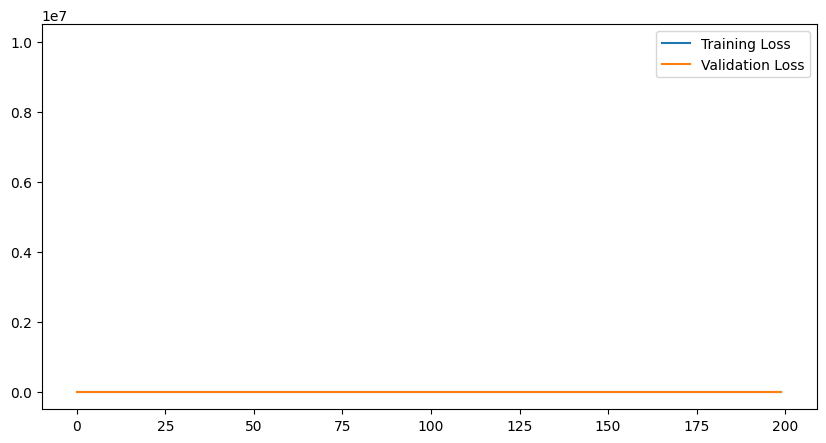

In [10]:
nepochs=200
quantiles=[0.1,0.5,0.9]
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

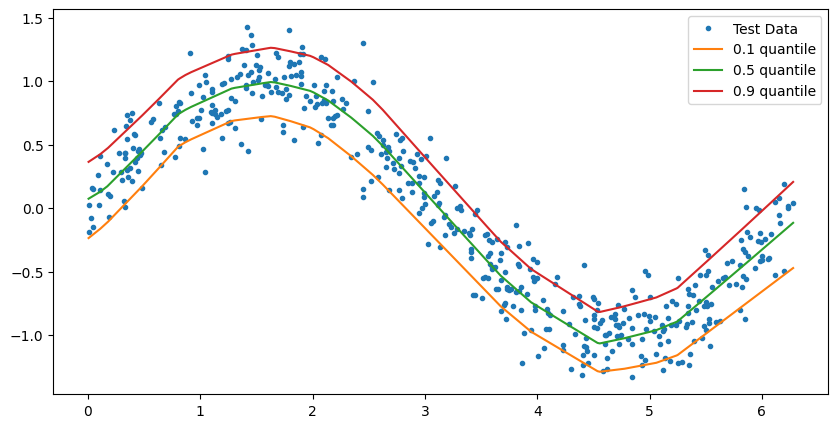

In [11]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [12]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.094, 0.476, 0.89 ])